In [316]:
from jupyter_client import find_connection_file
connection_file = find_connection_file()
print(connection_file)

/home/yonatan/.local/share/jupyter/runtime/kernel-v2-6096873X6bt0PYiF9.json


In [317]:
#Plotting related
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'

# Scikit-learn related imports
import pyarrow
import pandas as pd
pd.options.mode.copy_on_write = True
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint, ttest_ind
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions

In [318]:
df = pd.read_csv("../data/all_vaccines.csv")
df.head()

,Dataset,uid,geo_accession,biosample_accession,Donor,Age,IMMAGE,Gender,Virus,Vaccine,Strain,Day,Response,Cohort
0,GSE125921.SDY1529,SUB205386.1529,GSM3584988,NaN,YF00104002,27.0,0.193329,Male,Yellow Fever,YF-17D,Yellow Fever,D0,80.0,healthy aldults
1,GSE125921.SDY1529,SUB205386.1529,GSM3584988,NaN,YF00104002,27.0,0.193329,Male,Yellow Fever,YF-17D,Yellow Fever,FC,32.0,healthy aldults
2,GSE125921.SDY1529,SUB205386.1529,GSM3584988,NaN,YF00104002,27.0,0.193329,Male,Yellow Fever,YF-17D,Yellow Fever,D84,2560.0,healthy aldults
3,GSE125921.SDY1529,SUB205387.1529,GSM3584991,NaN,YF00104005,21.0,0.198895,Male,Yellow Fever,YF-17D,Yellow Fever,D0,80.0,healthy aldults
4,GSE125921.SDY1529,SUB205387.1529,GSM3584991,NaN,YF00104005,21.0,0.198895,Male,Yellow Fever,YF-17D,Yellow Fever,D84,1280.0,healthy aldults


In [319]:
dataset_col = "Dataset"
uid_col = "uid"
age_col = "Age"
day_col = "Day"
response_col = "Response"
immage_col = "IMMAGE"
strain_col = 'Strain'

current_dataset_num = 3

In [320]:
df[[dataset_col, uid_col, day_col]]

,Dataset,uid,Day
0,GSE125921.SDY1529,SUB205386.1529,D0
1,GSE125921.SDY1529,SUB205386.1529,FC
2,GSE125921.SDY1529,SUB205386.1529,D84
3,GSE125921.SDY1529,SUB205387.1529,D0
4,GSE125921.SDY1529,SUB205387.1529,D84
...,...,...,...
46494,SDY89,SUB114784.89,D28
46495,SDY89,SUB114784.89,D56
46496,SDY89,SUB114786.89,D196
46497,SDY89,SUB114786.89,D28


In [321]:
# drop missing values
df.dropna(inplace=True, subset=[immage_col, dataset_col, day_col, response_col])
dataset_names = df.Dataset.unique()

In [324]:
# Plot distribution of N values

N_vals = df[[dataset_col, uid_col]].groupby(dataset_col, as_index=False)[uid_col].nunique()
N_vals = N_vals.rename(columns={uid_col: "N"})
# sns.histplot(N_vals.N)

In [326]:
# Narrow N_v to large datasets only

N_vals = N_vals.loc[N_vals["N"]> 70]
datasets = df.loc[df["Dataset"].isin(N_vals["Dataset"])]
dataset_names = datasets["Dataset"].unique()
N_vals

,Dataset,N
6,GSE41080.SDY212,89
9,GSE48018.SDY1276,115
10,GSE48023.SDY1276,110
22,SDY67,159


In [327]:
# Examine available days per dataset
days = datasets[[dataset_col, uid_col, day_col]].groupby(dataset_col, as_index=False)[day_col].unique()
t = pd.Series(days.loc[[True, False, False, False], "Day"])
with pd.option_context('display.max_colwidth', None):
   for index, row in days.iterrows():
    print(f"Dataset: {row['Dataset']}\nDays: {row['Day']}\n\n")
 


Dataset: GSE41080.SDY212
Days: ['HAI.D0' 'FC.HAI' 'HAI.D28' 'HAI.maxRBA' 'HAI.RBA.Post' 'HAI.MFC.Post'
 'HAI.MFC']


Dataset: GSE48018.SDY1276
Days: ['nAb.D14' 'nAb.D28' 'nAb.D0' 'nAb.FC' 'HAI.D14' 'HAI.D28' 'HAI.D0'
 'HAI.FC' 'HAI.MFC' 'HAI.RBA.Post' 'HAI.MFC.Post' 'HAI.maxRBA']


Dataset: GSE48023.SDY1276
Days: ['nAb.FC' 'nAb.D0' 'nAb.D28' 'nAb.D14' 'HAI.FC' 'HAI.D14' 'HAI.D28'
 'HAI.D0']


Dataset: SDY67
Days: ['HAI.D0' 'HAI.MFC.Post' 'nAb.D0' 'nAb.D28' 'HAI.maxRBA' 'FC.D28.HAI'
 'HAI.D28' 'HAI.MFC' 'FC.D75.HAI' 'FC.D75.nAb' 'HAI.D3' 'nAb.D3'
 'FC.D28.nAb' 'HAI.D75' 'HAI.RBA.Post' 'nAb.D75']




In [375]:
# Collect day info from papers here
dataset_day_dict = {}

dataset_day_dict["GSE41080.SDY212"] = "HAI.D28"
dataset_day_dict["GSE48018.SDY1276"] = "nAb.D28"
dataset_day_dict["GSE48023.SDY1276"] = "nAb.D28"
dataset_day_dict["SDY67"] = "nAb.D28"
dataset_day_dict[dataset_names[0]]

'HAI.D28'

In [376]:
# Narrow to a specific dataset and day, then keep only relevant columns
dataset_name = dataset_names[0]
name_mask = datasets[dataset_col] == dataset_name
day_mask = datasets[day_col] == dataset_day_dict[dataset_name]

data = datasets.loc[(name_mask) & (day_mask)].reset_index()

# Somtimes there are multiple strains - so multiple rows per day
strains = data[strain_col].unique()
if len(strains) > 1:
   data = data.loc[data[strain_col] == strains[0]].reset_index()

# Take relevant columns only
data = data[[immage_col, response_col, age_col]]

dataset_name

'GSE41080.SDY212'

In [377]:
# Get a boolean map of sub and super threshold values
# Note that we define y=1 for all responses >= 30th percentile (and not >)

low_response_thr = data[[response_col]].quantile(q=0.3).item()
# high_response_thr = responses.quantile(q=0.7).item()  

# Generate labels
data.loc[data[response_col] < low_response_thr, 'y'] = 0
data.loc[data[response_col] >= low_response_thr, 'y'] = 1
data.y = data.y.astype(int)

# Add a text label for plot legends
data['Label text'] = data['y'].apply(lambda x: 'Responders' if x == 1 else 'Non-Responders')
 
data

,IMMAGE,Response,Age,y,Label text
0,0.237785,160.0,24.07,1,Responders
1,0.155243,40.0,24.97,0,Non-Responders
2,0.112590,160.0,84.06,1,Responders
3,-0.100949,320.0,61.84,1,Responders
4,-0.226173,320.0,62.86,1,Responders
...,...,...,...,...,...
84,-0.128028,160.0,28.11,1,Responders
85,0.042327,1280.0,23.82,1,Responders
86,0.052453,320.0,20.68,1,Responders
87,0.193562,1280.0,84.28,1,Responders


In [378]:
print(f"Total N={data.shape[0]}")

Total N=89


In [379]:
# # sanity check for logistic regression - create a seperable dataset

# mask =  pd.Series(data['y'] == 1)
# counts = mask.value_counts()

# data.loc[~mask, immage_col] = np.random.uniform(low=0, high=0.4, size=[counts[False], 1])
# data.loc[mask, immage_col] = np.random.uniform(high=1, low=0.6, size=[counts[True], 1])
# # data = pd.concat([data, data[data["Labels"] == False].tail(3)], ignore_index=True)
dataset_name

'GSE41080.SDY212'

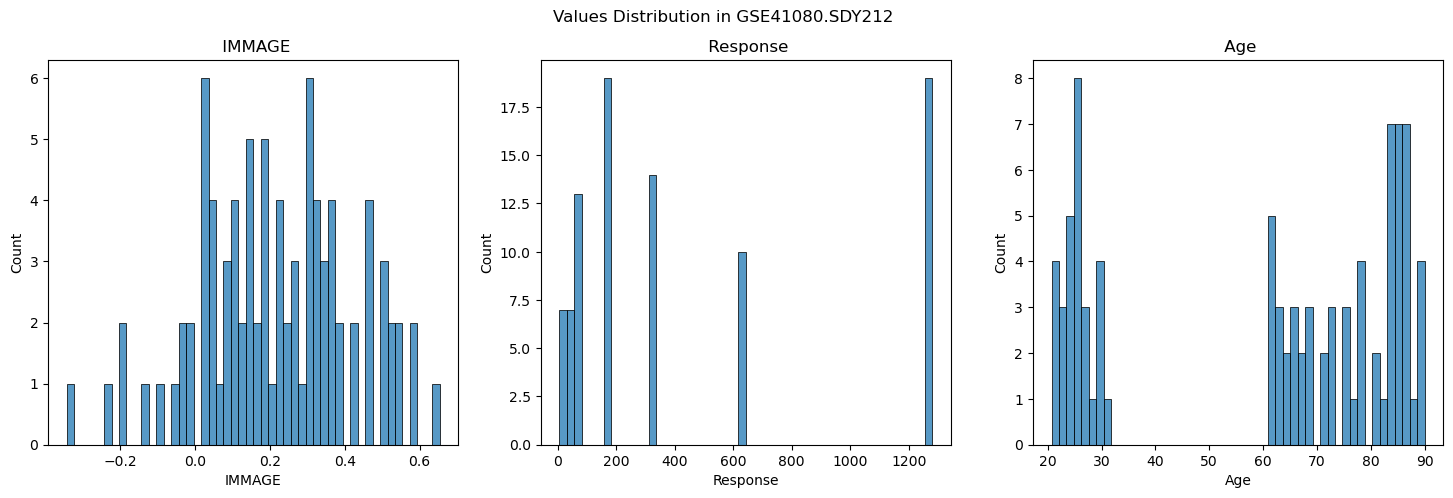

In [380]:
# Plot IMMAGE, response, and age values to look at the dynamic range
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Adjust figsize as needed
pd.concat
sns.histplot(data=data, x=immage_col, bins=50, ax=axs[0])
axs[0].set_title(f' {immage_col}')

sns.histplot(data=data, x=response_col, bins=50, ax=axs[1])
axs[1].set_title(f' {response_col}')

sns.histplot(data=data, x=age_col, bins=50, ax=axs[2])
axs[2].set_title(f' {age_col}')

fig.suptitle(f'Values Distribution in {dataset_name}')

plt.show()

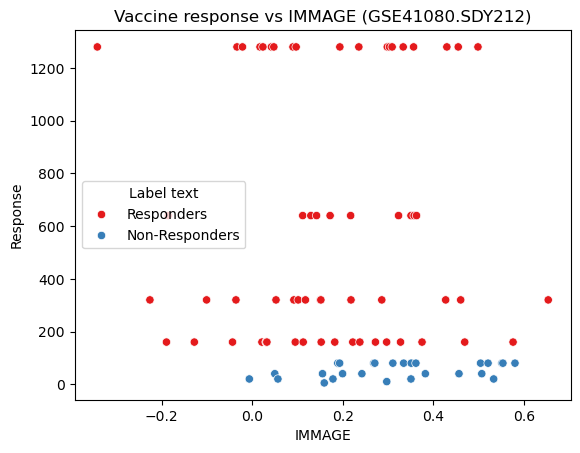

In [381]:
# Is there a trend like we expect?
# Plot the response value against sorted IMMAGE, with markers signifying labels
sorted_data = data.sort_values(by="IMMAGE")
sns.scatterplot(data=sorted_data, x="IMMAGE", y="Response", hue="Label text", palette='Set1')
plt.title(f'Vaccine response vs IMMAGE ({dataset_name})')
plt.show()

In [382]:
# Running a t-test
low_group = data.loc[data[response_col]  < low_response_thr, immage_col]
high_group = data.loc[data[response_col]  >= low_response_thr, immage_col]
print(f"low group N={low_group.shape[0]}, high group N={high_group.shape[0]}")

ttest = ttest_ind(low_group, high_group)
print(f"pvalue: {ttest.pvalue}")

low group N=27, high group N=62
pvalue: 0.001701136116823267


In [383]:
# Classifying with logistic regression
log_regress = LogisticRegression()
regression_result = cross_validate(log_regress, data[[immage_col]],  data["y"])
regression_result['test_score'].mean()

0.6967320261437908

In [384]:
# Split the data into training and testing sets
X_train, X_test, labels_train, labels_test = train_test_split(data[[immage_col]], data["y"], test_size=0.2, random_state=42)

log_regress.fit(X_train, labels_train)
log_regress.score(X_test, labels_test)

beta_0 = log_regress.intercept_[0]
beta_1 = log_regress.coef_[0][0]


print(f'{beta_0}, {beta_1}')
# Calculate the cutoff value
cutoff = -beta_0 / beta_1

print(f"IMMAGE cutoff value is: {cutoff}")

0.893363987174833, -1.2410188403672195
IMMAGE cutoff value is: 0.719863355910443


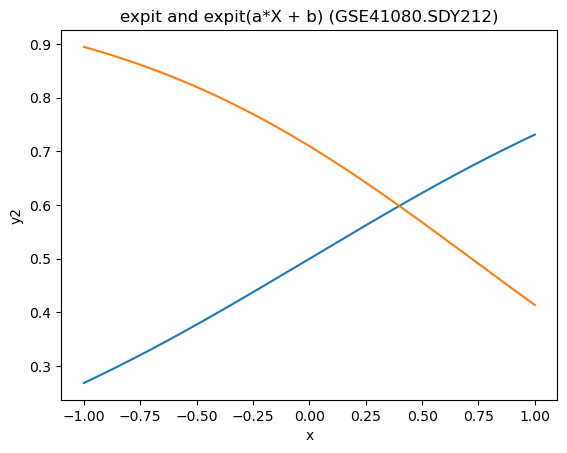

In [385]:
# Plot the logistic regression decision function
from scipy.special import expit
dft = pd.DataFrame()
dft["x"] = np.linspace(-1, 1, 500)
dft["y"] = beta_0 + dft.x * beta_1
dft["y2"] = expit(dft.x)
dft["y3"] = expit(dft.y)
sns.lineplot(data=dft, x="x", y="y2")
sns.lineplot(data=dft, x="x", y="y3")
plt.title(f'expit and expit(a*X + b) ({dataset_name})')
plt.show()

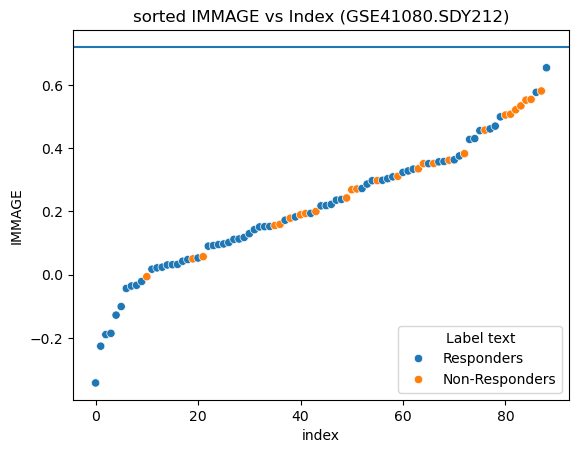

In [386]:
# Plot IMMAGE values and the cutoff
sns.scatterplot(data=data.sort_values(immage_col, ignore_index=True).reset_index(), x="index", y=immage_col, hue="Label text")
# commented out since cutoff is much higher and messes with the plot
plt.axhline(y=cutoff)
plt.title(f'sorted IMMAGE vs Index ({dataset_name})')
plt.show()

In [431]:
n_bins = 6
B = pd.cut(data["IMMAGE"], bins=n_bins, labels=range(n_bins))
data["bin"] = B.values.astype(int)

grouped = data.groupby("bin", as_index=False)['y'].mean().apply(lambda x: 1-x)
grouped.apply(print)
# for key, item in grouped:
#     print(grouped.get_group(key), "\n\n")


0    1
1    0
2   -1
3   -2
4   -3
5   -4
Name: bin, dtype: int64
0    0.000000
1    0.000000
2    0.153846
3    0.416667
4    0.315789
5    0.700000
Name: y, dtype: float64


bin    None
y      None
dtype: object

In [432]:
B

0     3
1     2
2     2
3     1
4     0
     ..
84    1
85    2
86    2
87    3
88    3
Name: IMMAGE, Length: 89, dtype: category
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]

In [ ]:
from sklearn.metrics import auc, roc_auc_score, roc_curve

pr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Identifying the optimal threshold (example using Youden’s Index)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]